In [33]:
# Tuan Pham, Victoria Hall, Alexy Correa, Sahil Jain  

# Final Project

We decide to do this project ....

In [34]:
#You may add additional imports
import warnings
#warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import time

In [35]:
import numpy as np
import pandas as pd
print("Imported libraries")

Imported libraries


# Data Prep
Here we clean up the raw data to use.

Data prep includes:
* Split Month/Day/Year column to 3 different columns
* Replace None values with 0  
* Removing "$" from the data set

https://www.kaggle.com/datasets/deepcontractor/unicorn-companies-dataset

In [36]:
# Data Cleaning
df = pd.read_csv('Unicorn_Companies.csv')

# Replace 4/17/2015 -> 3 separate columns on Month/Day/Year Joined
df[['Month Joined', 'Day Joined', 'Year Joined']] = df['Date Joined'].str.split('/', 3, expand=True)
df.drop('Date Joined', axis=1, inplace=True)

# Replace Nones in Numerical Data with 0
# Did not do it for 'Financial Stage' since it's categorical
df['Portfolio Exits'] = df['Portfolio Exits'].replace('None', 0)
df['Total Raised'] = df['Total Raised'].replace('None', '$0M')
df['Investors Count'] = df['Investors Count'].replace('None', 0)
df['Valuation ($B)'] = df['Valuation ($B)'].replace('None', '$0')
df['Founded Year'] = df['Founded Year'].replace('None', 0) # I say we kick these entries out but I'm leaving it at 0 for now
df['Deal Terms'] = df['Deal Terms'].replace('None', 0)

# Removed $ from data
df['Valuation ($B)'] = df['Valuation ($B)'].str[1:]

# Convert $M and $B to just $M
df['Total Raised ($M)'] = df['Total Raised'].str[1:-1]
df['Total Raised ($M)'] = pd.to_numeric(df['Total Raised ($M)'])
df.loc[df['Total Raised'].str[-1] == 'B', 'Total Raised ($M)'] *= 1000
df.drop('Total Raised', axis=1, inplace=True)

# Convert numerical data into floats/ints
df[['Valuation ($B)', 'Founded Year', 'Investors Count']] = df[['Valuation ($B)', 'Founded Year', 'Investors Count']].apply(pd.to_numeric)
df[['Deal Terms', 'Portfolio Exits', 'Month Joined']] = df[['Deal Terms', 'Portfolio Exits', 'Month Joined']].apply(pd.to_numeric)
df[['Day Joined', 'Year Joined', 'Total Raised ($M)']] = df[['Day Joined', 'Year Joined', 'Total Raised ($M)']].apply(pd.to_numeric)

# combine "artificial intelligence" together
df['Industry'] = df['Industry'].replace('Artificial Intelligence', 'Artificial intelligence')
# main categories for industry
categories = ['Artificial intelligence', 'Auto & transportation', 'Consumer & retail', 'Cybersecurity',
'Data management & analytics', 'E-commerce & direct-to-consumer',
'Internet software & services', 'Health', 'Hardware', 'Fintech', 'Edtech',
'Travel', 'Supply chain, logistics, & delivery', 'Other', 'Mobile & telecommunications']
# moving specific investors in industry to be considered investments
df.loc[~df['Industry'].isin(categories), 'Industry'] = 'Investments'

df.head()

,Company,Valuation ($B),Country,City,Industry,Select Inverstors,Founded Year,Financial Stage,Investors Count,Deal Terms,Portfolio Exits,Month Joined,Day Joined,Year Joined,Total Raised ($M)
0,Bytedance,140.0,China,Beijing,Artificial intelligence,"Sequoia Capital China, SIG Asia Investments, S...",2012,IPO,28,8,5,4,7,2017,7440.0
1,SpaceX,100.3,United States,Hawthorne,Other,"Founders Fund, Draper Fisher Jurvetson, Rothen...",2002,None,29,12,0,12,1,2012,6874.0
2,Stripe,95.0,United States,San Francisco,Fintech,"Khosla Ventures, LowercaseCapital, capitalG",2010,Asset,39,12,1,1,23,2014,2901.0
3,Klarna,45.6,Sweden,Stockholm,Fintech,"Institutional Venture Partners, Sequoia Capita...",2005,Acquired,56,13,1,12,12,2011,3472.0
4,Epic Games,42.0,United States,Cary,Other,"Tencent Holdings, KKR, Smash Ventures",1991,Acquired,25,5,2,10,26,2018,4377.0


# Data Exploration
mean, median, mode, range....
Printing graphs, boxplot, distributions...
categorical varibles to frequency table
correlation for continuous



----------- Valuation ($B) -----------

3.2920829315332583
1.6
140.0
1.0


<AxesSubplot:>

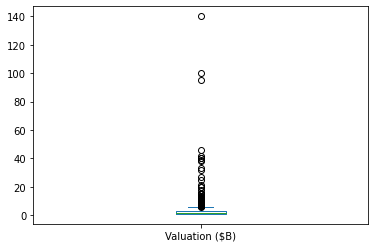

In [37]:
print("\n----------- Valuation ($B) -----------\n")
print(df['Valuation ($B)'].mean())
print(df['Valuation ($B)'].median())
print(df['Valuation ($B)'].max())
print(df['Valuation ($B)'].min())
# df['Valuation ($B)'].value_counts().plot.bar()
df.dtypes
df['Valuation ($B)'].plot(x='class', kind='box')


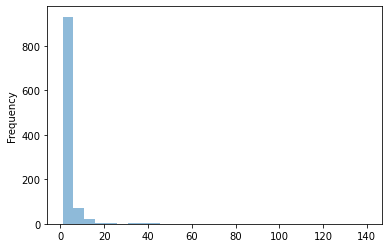

In [38]:
ax = df['Valuation ($B)'].plot.hist(bins=28, alpha=0.5)
# after seeing the distribution, we decided to only use compnies with valuation less than $2B

In [39]:
df = df[df['Valuation ($B)'] <= 2]
print(df.shape)
# df.head()
# print("here")

(645, 15)


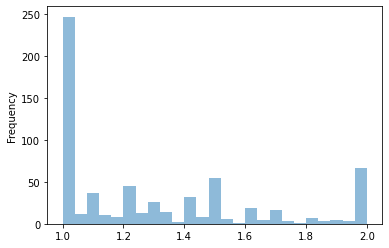

In [40]:
ax = df['Valuation ($B)'].plot.hist(bins=25, alpha=0.5)


----------- Investors Count -----------

mean:  12.655813953488373
median:  11.0
max:  91
min:  0
whisker:  29.5


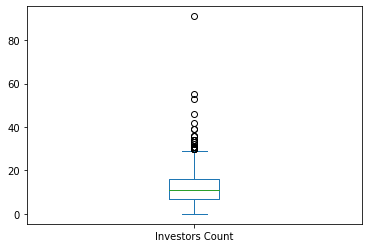

In [41]:
# now we can look at other catergories
print("\n----------- Investors Count -----------\n")
print("mean: ",df['Investors Count'].mean())
print("median: ",df['Investors Count'].median())
print("max: ",df['Investors Count'].max())
print("min: ",df['Investors Count'].min())
# df['Investors Count'].value_counts().plot.bar()
df['Investors Count'].plot(x='class', kind='box')

# Note after seeing the boxplot, we decided to take up to the maximum in whisker boxplot...
whisker = 1.5 * (df['Investors Count'].quantile(.75) - df['Investors Count'].quantile(.25))
whisker += df['Investors Count'].quantile(.75)
print("whisker: ", whisker)
df = df[df['Investors Count'] <= 29.5]



<AxesSubplot:>

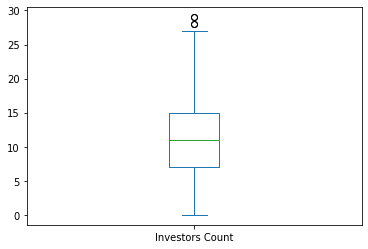

In [42]:
df = df[df['Investors Count'] <= 29.5]
df['Investors Count'].plot(x='class', kind='box')


-----------Founded Year-----------

mean:  1908.6763754045307
median:  2014.0
max:  2021
min:  0
whisker_upper:  2025.0
whisker_lower:  2001.0


<AxesSubplot:>

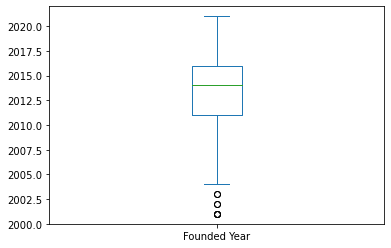

In [43]:
# Filter out the founded year bc we want to see how long it'll take ...
print("\n-----------Founded Year-----------\n")
print("mean: ",df['Founded Year'].mean())
print("median: ",df['Founded Year'].median())
print("max: ",df['Founded Year'].max())
print("min: ",df['Founded Year'].min())

# Note after seeing the boxplot, we decided to take up to the maximum in whisker boxplot...
IQR = 1.5 * (df['Founded Year'].quantile(.75) - df['Founded Year'].quantile(.25))
whisker_upper = df['Founded Year'].quantile(.75) + IQR
whisker_lower = df['Founded Year'].quantile(.25) - IQR

print("whisker_upper: ", whisker_upper)
print("whisker_lower: ", whisker_lower)
df = df[df['Founded Year'] <= whisker_upper]
df = df[df['Founded Year'] >= whisker_lower]

df['Founded Year'].plot(x='class', kind='box')

<AxesSubplot:xlabel='Industry'>

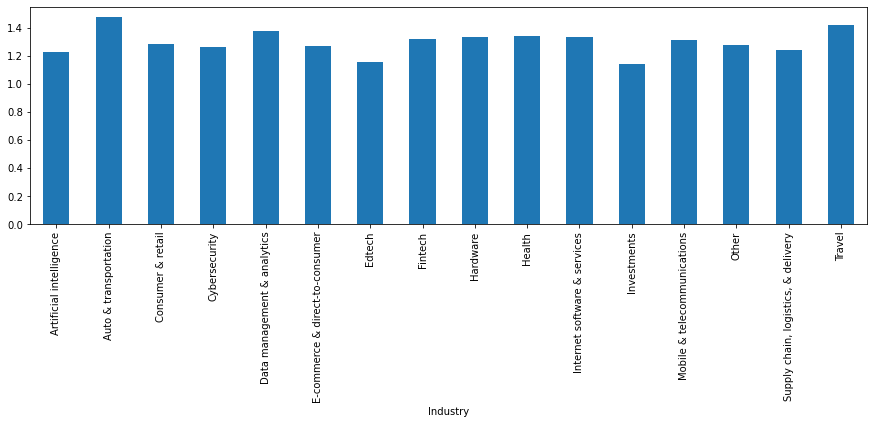

In [44]:
# relationship between valuation vs ... country, industry, year founded
# TODO: Let's flip this and add title and y-label
df.groupby(['Industry'])['Valuation ($B)'].mean().plot.bar(figsize=(15,4))

<AxesSubplot:xlabel='Founded Year'>

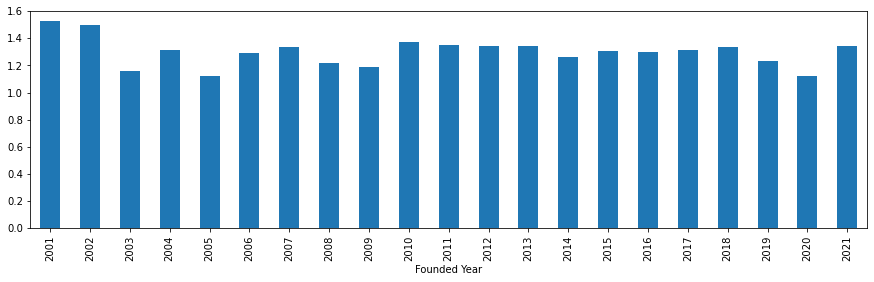

In [45]:
df.groupby(['Founded Year'])['Valuation ($B)'].mean().plot.bar(figsize=(15,4))

<AxesSubplot:xlabel='Country'>

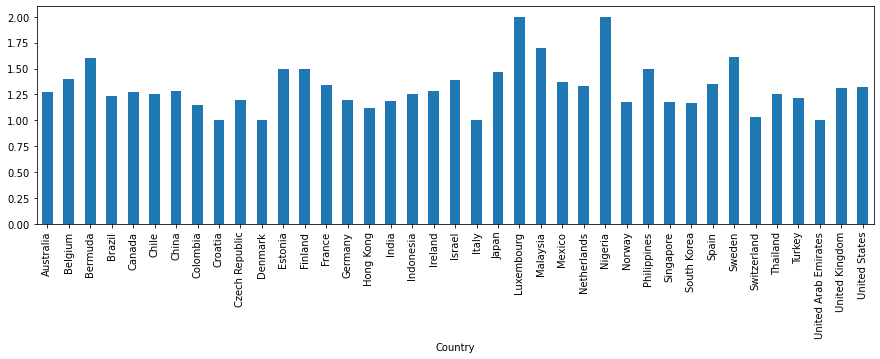

In [46]:
df.groupby(['Country'])['Valuation ($B)'].mean().plot.bar(figsize=(15,4))

# Feature Engineering
One hot encoding for categorical variables, binning for valuation, pca?
....


In [47]:
# one-hot encoding categorical variables
one_country = pd.get_dummies(df["Country"], prefix="Country")
df = df.join(one_country)

one_industry = pd.get_dummies(df["Industry"], prefix="Industry")
df = df.join(one_industry)

one_stage = pd.get_dummies(df["Financial Stage"], prefix="Financial Stage")
df = df.join(one_stage)

# remove these after making the one-hot-encoding
df = df.drop(['Country'], axis = 1)
df = df.drop(['Industry'], axis = 1)
df = df.drop(['Financial Stage'], axis = 1)

df.head()

,Company,Valuation ($B),City,Select Inverstors,Founded Year,Investors Count,Deal Terms,Portfolio Exits,Month Joined,Day Joined,...,Industry_Other,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse
319,Xinchao Media,2.0,Chengdu,"JD.com, Baidu, Vision Plus Capital",2007,8,4,1,4,9,...,0,0,0,0,0,0,0,1,0,0
392,BlaBlaCar,2.0,Paris,"Accel Partners, Index Ventures, Insight Ventur...",2006,13,6,0,9,16,...,0,0,0,0,0,0,0,0,1,0
393,HuiMin,2.0,Beijing,"Zheshang Venture Capital, GP Capital, Western ...",2013,13,1,0,9,5,...,0,0,0,0,0,0,0,0,1,0
394,Quora,2.0,Mountain View,"Y Combinator, Matrix Partners, Benchmark",2009,10,5,0,4,21,...,0,0,0,0,0,0,0,0,1,0
395,Improbable,2.0,London,"Andreessen Horowitz, SoftBank Group, Temasek H...",2012,7,4,0,5,11,...,1,0,0,0,0,0,0,0,1,0


In [48]:
# after looking at the data set, we decided to ...
# remove: city, select inverstors, month joined, day joined, founded year, year joined
df = df.drop(['City'], axis = 1)
df = df.drop(['Select Inverstors'], axis = 1)
df = df.drop(['Month Joined'], axis = 1)
df = df.drop(['Day Joined'], axis = 1)

# remove: entries with 0 for founded year and year joined
df = df[df['Founded Year'] != 0]
df = df[df['Year Joined'] != 0]

# create: time to join: year joined - founded year
df['Time til Unicorn'] = df['Year Joined'] - df['Founded Year']
df = df.drop(['Founded Year'], axis = 1)
df = df.drop(['Year Joined'], axis = 1)

In [49]:
# move 'Time til Unicorn' closer to thr front
unicorn_time = df.pop('Time til Unicorn')
df.insert(3, 'Time til Unicorn', unicorn_time)

df.head()

,Company,Valuation ($B),Investors Count,Time til Unicorn,Deal Terms,Portfolio Exits,Total Raised ($M),Country_Australia,Country_Belgium,Country_Bermuda,...,Industry_Other,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse
319,Xinchao Media,2.0,8,11,4,1,1330.00,0,0,0,...,0,0,0,0,0,0,0,1,0,0
392,BlaBlaCar,2.0,13,9,6,0,564.30,0,0,0,...,0,0,0,0,0,0,0,0,1,0
393,HuiMin,2.0,13,3,1,0,519.63,0,0,0,...,0,0,0,0,0,0,0,0,1,0
394,Quora,2.0,10,8,5,0,286.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0
395,Improbable,2.0,7,5,4,0,603.93,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [50]:
# binning valuation -- currently, values range from [1, 2], and we bin them into 11 bins by 0.1
num_bins = 7
valuation_min = df['Valuation ($B)'].min()
df['Valuation Bins'] = np.floor(((df['Valuation ($B)'] - valuation_min) * num_bins))
df = df.drop(['Valuation ($B)'], axis = 1)
df.head()

,Company,Investors Count,Time til Unicorn,Deal Terms,Portfolio Exits,Total Raised ($M),Country_Australia,Country_Belgium,Country_Bermuda,Country_Brazil,...,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse,Valuation Bins
319,Xinchao Media,8,11,4,1,1330.00,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7.0
392,BlaBlaCar,13,9,6,0,564.30,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.0
393,HuiMin,13,3,1,0,519.63,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.0
394,Quora,10,8,5,0,286.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.0
395,Improbable,7,5,4,0,603.93,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7.0


In [51]:
# move 'Valuation Bins' closer to thr front
val_bin = df.pop('Valuation Bins')
df.insert(1, 'Valuation Bins', val_bin)

df.head()

,Company,Valuation Bins,Investors Count,Time til Unicorn,Deal Terms,Portfolio Exits,Total Raised ($M),Country_Australia,Country_Belgium,Country_Bermuda,...,Industry_Other,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse
319,Xinchao Media,7.0,8,11,4,1,1330.00,0,0,0,...,0,0,0,0,0,0,0,1,0,0
392,BlaBlaCar,7.0,13,9,6,0,564.30,0,0,0,...,0,0,0,0,0,0,0,0,1,0
393,HuiMin,7.0,13,3,1,0,519.63,0,0,0,...,0,0,0,0,0,0,0,0,1,0
394,Quora,7.0,10,8,5,0,286.00,0,0,0,...,0,0,0,0,0,0,0,0,1,0
395,Improbable,7.0,7,5,4,0,603.93,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [52]:
df = df.drop(['Company'], axis = 1)
df.head()

,Valuation Bins,Investors Count,Time til Unicorn,Deal Terms,Portfolio Exits,Total Raised ($M),Country_Australia,Country_Belgium,Country_Bermuda,Country_Brazil,...,Industry_Other,"Industry_Supply chain, logistics, & delivery",Industry_Travel,Financial Stage_Acq,Financial Stage_Acquired,Financial Stage_Corporate,Financial Stage_Divestiture,Financial Stage_IPO,Financial Stage_None,Financial Stage_Reverse
319,7.0,8,11,4,1,1330.00,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
392,7.0,13,9,6,0,564.30,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
393,7.0,13,3,1,0,519.63,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
394,7.0,10,8,5,0,286.00,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
395,7.0,7,5,4,0,603.93,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [53]:
# df.groupby('Valuation Bins').count()
df['Valuation Bins'].value_counts()

0.0    257
1.0     66
3.0     64
2.0     63
7.0     59
4.0     35
5.0     12
6.0      6
Name: Valuation Bins, dtype: int64

# 	Data Analysis: 
decision tree, 
knn
naive bayes 1
....51068

In [54]:
# creating training and test set
labels = df['Valuation Bins'].values.ravel()
features = df.drop(['Valuation Bins'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [56]:
#-------KNN------------
# imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.pipeline import Pipeline
# imblanced learning
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline

# creating objects
pca = PCA()
enn = EditedNearestNeighbours()
smote = SMOTE(random_state=0)
knn = KNeighborsClassifier(n_neighbors=7)
scaler = StandardScaler()
pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('enn', enn),\
                                               ('sampling', smote),('knn', knn)])
# pipeline = make_pipeline(scaler, pca, enn, smote, knn)

# cross validation
nested_score = cross_val_score(pipeline, x_train, y_train, cv=5)
print("Accuracy:", nested_score.mean()*100)

param_grid = {
    'pca__n_components': list(range(5, 20)),
    'knn__n_neighbors': list(range(1, 68))
}

# grid_search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

C:\Users\tuani\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tuani\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tuani\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y,

Accuracy: nan


In [ ]:
# best outcomes
print("Best params: ", grid_search.best_params_)
print("Accuracy: ", grid_search.best_score_*100)

# cross validation
nested_score = cross_val_score(grid_search, x_train, y_train, cv=5)
print("Accuracy:", nested_score.mean()*100)

In [ ]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.47      0.87      0.61        54
         1.0       0.17      0.08      0.11        12
         2.0       0.00      0.00      0.00         6
         3.0       0.00      0.00      0.00         6
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00        15
         6.0       0.00      0.00      0.00         3
         7.0       0.00      0.00      0.00         4
         8.0       0.00      0.00      0.00         2
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         8

    accuracy                           0.42       113
   macro avg       0.06      0.09      0.07       113
weighted avg       0.24      0.42      0.30       113



C:\Users\tuani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tuani\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 	Outcome / Results: 
how did we do?
show some predictions
F1, confusion matrix
....